In [22]:
import spacy, benepar
#benepar.download('benepar_en3')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [24]:
nlp = spacy.load('en_core_web_md')

In [25]:
if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"})

In [26]:
import sys
sys.path.append('../')
from FullParser.ClauseParser import ClauseParser
import pandas as pd

In [27]:
parser = ClauseParser()

In [28]:
def read_file(file_path):
    with open(file_path, 'r', encoding = 'utf-8') as f:
        for line in f:
            yield line

In [29]:
dolma_path = "../Datasets/dolma/dolma/dolma_text/"
current_file = "v1_5r2_sample-0005.txt"

In [ ]:
t = time.time()
times = []
line_count = 1
ECs = []
for line in read_file(dolma_path+current_file):
    sline = line.strip('\n')
    if len(line) <100 :
        try:
            doc = nlp(sline)
            for sent in doc.sents:
                parse = parser.parse_clauses(sent)
                if parse != []:
                    # print(f'Line {line_count} has an embedded clause!')
                    ECs.append(parse)
        except Exception as e:
            #print(f"Error encountered while processing line {line_count}: {sline}")
            print(e)
            pass  # Do nothing, continue to next line
    line_count+=1
    if line_count % 1000 == 0:
        print(f'Time to parse 1000 entries: {time.time()-t}')
        times.append(time.time()-t)
        t = time.time()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/homebrew/Caskroom/miniconda/base/envs/benepar_env/lib/python3.12/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Time to parse 1000 entries: 7.225481986999512
Time to parse 1000 entries: 11.765776872634888
Time to parse 1000 entries: 9.290253162384033
Time to parse 1000 entries: 10.402081966400146
Time to parse 1000 entries: 10.427428245544434
Time to parse 1000 entries: 7.524231910705566
list index out of range
Time to parse 1000 entries: 12.412753820419312
Time to parse 1000 entries: 6.825866937637329
Time to parse 1000 entries: 8.22856092453003
Time to parse 1000 entries: 9.013823986053467
Time to parse 1000 entries: 8.099301099777222
Time to parse 1000 entries: 8.176020860671997
Time to parse 1000 entries: 8.328272104263306
Time to parse 1000 entries: 8.882029056549072
Time to parse 1000 entries: 9.2603919506073
Time to parse 1000 entries: 10.003523111343384
Time to parse 1000 entries: 8.530061960220337
Time to parse 1000 entries: 7.997726917266846


Time to parse 1000 entries: 7.624527215957642
Time to parse 1000 entries: 8.253080129623413
Time to parse 1000 entries: 10.037407159805298
Time 

In [12]:
len(ECs)

395

In [45]:
1000*(np.sum(times)/60/60)

0.15009639435610203

In [19]:
predicates = []
long_pred_count = 0
for entry in ECs:
    for clause in entry:
        if not clause['predicate']:
            continue
        pred_string = ''
        if len(clause['predicate'])>4:
            long_pred_count += 1
            continue
        for pred in clause['predicate']:
            pred_string += pred['str']
        predicates.append(pred_string)

In [18]:
np.unique(predicates, return_counts=True)

(array(["'msure", '-See', 'Administerreferenced', 'AvoidFancy', 'Bakefor',
        'Bakeforin', 'Bringto', 'Call', 'Checkout', 'Contact',
        'Continuing', 'Determine', 'Discover', 'Do', 'Ensure', 'Get',
        'Goingon', 'Hope', 'Increaseto', 'Know', 'Learn', 'Listen',
        'Looks', 'Makesure', 'Place1st', 'Process', 'Remember', 'Remove',
        'Reviewsignreturn', 'Rewritebeginningshown', 'Rinse', 'Say',
        'Says', 'Saywantengage', 'See', 'Servewithwarm', 'Stirin', 'Tell',
        'Telltreating', 'Thinking', 'Turnon', 'Use', 'Waiting', 'Wear',
        'Wish', 'Write', 'aboutleave', 'added', 'admits', 'admitted',
        'advised', 'agreewith', 'amafraid', 'announce', 'answer',
        'appears', 'appreciating', 'arecertainmend', 'aresimilartofixed',
        'aresure', 'arewrong', 'asked', 'asks', 'assess', 'attachedof',
        'await', 'basedon', 'becomeeasier', 'bedry', 'behappy', 'believe',
        'beproductive', 'besurprised', 'bet', 'broke', 'call', 'callat',
    

'turn'

<BarContainer object of 6607 artists>

/opt/homebrew/Caskroom/miniconda/base/envs/benepar_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127815 (\N{GRAPES}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/benepar_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127815 (\N{GRAPES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


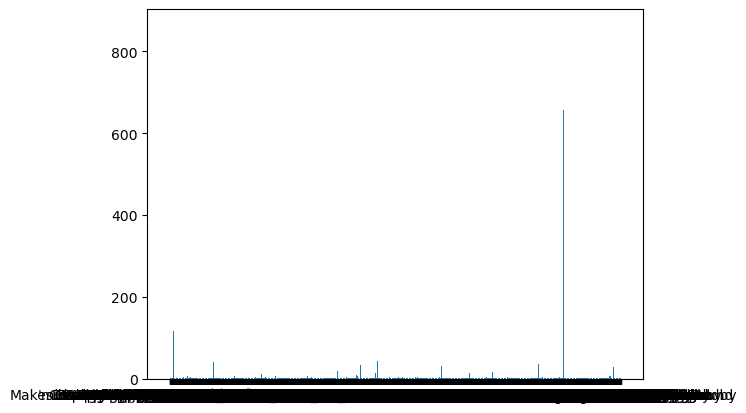

In [95]:
(lambda x: plt.bar(x[0],x[1]))(np.unique(predicates, return_counts=True))

(array([ 1.,  0.,  1.,  2.,  1.,  0.,  3.,  1.,  1.,  1.,  6.,  6.,  5.,
         8.,  9., 14., 13., 23., 12., 16., 22., 26., 22., 27., 23., 29.,
        29., 23., 21., 19., 25., 13., 26., 26., 14., 11., 16., 11., 13.,
         9., 13., 11.,  5.,  8.,  8.,  6.,  2.,  2.,  5.,  4.,  3.,  2.,
         4.,  1.,  1.,  3.,  2.,  3.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,
         1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 5.7091372 ,  5.86256789,  6.01599858,  6.16942927,  6.32285995,
         6.47629064,  6.62972133,  6.78315202,  6.93658271,  7.0900134 ,
         7.24344409,  7.39687477,  7.55030546,  7.70373615,  7.85716684,
         8.01059753,  8.16402822,  8.3174589 ,  8.47088959,  8.62432028,
         8.77775097,  8.93118166,  9.08461235,  9.23804303,  9.39147372,
         9.54490441,  9.6983351 ,  9.85176579, 10.00519648, 10.158627

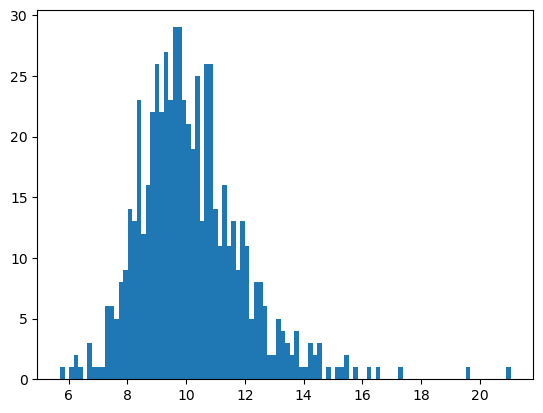

In [41]:
plt.hist(times,bins=100)